<a href="https://colab.research.google.com/github/nudojacopo/thesis/blob/main/src/EDA/EDA_draw/draw_participation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [13]:
!git clone https://github.com/nudojacopo/thesis.git
from google.colab import drive
drive.mount('/content/drive')
root='/content/'
import sys
module_path = root+'thesis/src/SYN'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
!pip install powerlaw
from SYN_package.functions import *
from SYN_package.estimate_parameters import *
import json
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import powerlaw
import warnings

fatal: destination path 'thesis' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Prepare Data

In [14]:
rd=pd.read_csv('/content/drive/MyDrive/thesis/data/reddit/reddit_PRO.csv')

fb=pd.read_csv('/content/drive/MyDrive/thesis/data/facebook/facebook_news_PRO.csv')

vo=pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_PRO.csv')

gb=pd.read_csv('/content/drive/MyDrive/thesis/data/gab/gab_PRO.csv')


In [15]:
fb=filter_first_h(fb,100)

gb=filter_first_h(gb,100)

rd=filter_first_h(rd,100)

vo=filter_first_h(vo,100)

In [16]:
names = ['gb','rd','fb','vo']
datas = [gb,rd,fb,vo]

## Simulate synthetic data

In [26]:

for i, df in enumerate(datas):
    social = names[i]
    parameters = params_dict[social]

    observed = df[['user_id', 'post_id', 'temporal_distance_birth_base_100h', 'sequential_number_of_comment_by_user_in_thread']]
    globals()[f"{social}o_M1"] = observed







<ipython-input-47-c81e4ecd8277>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdo_M1['platform'] = 'Reddit'
<ipython-input-47-c81e4ecd8277>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voo_M1['platform'] = 'Voat'
<ipython-input-47-c81e4ecd8277>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

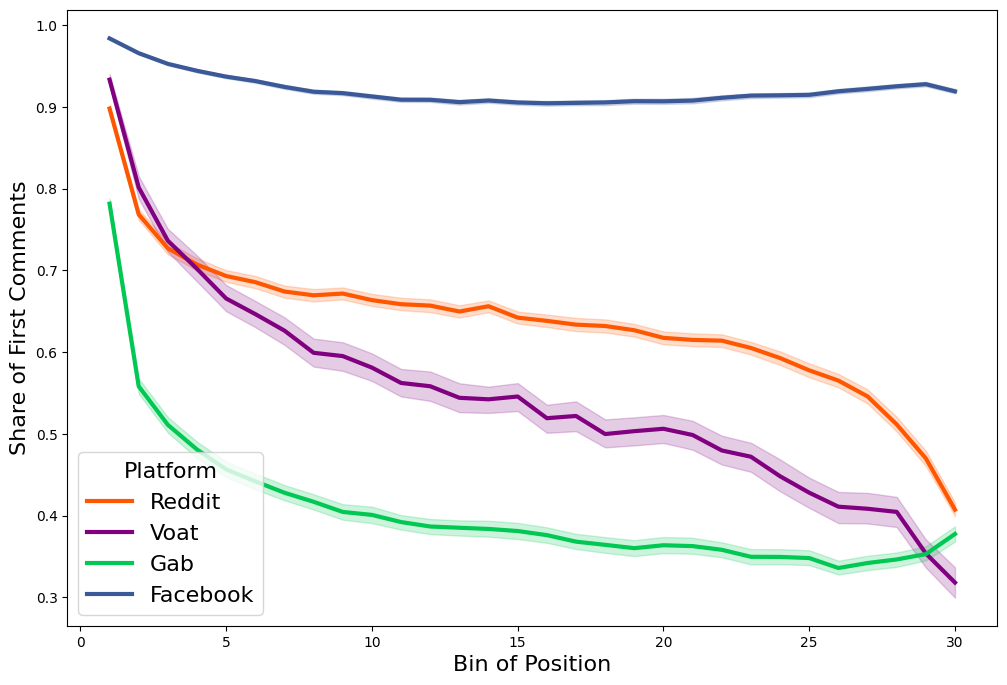

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Supponiamo che rdo_M1, voo_M1, fbo_M1, gbo_M1 siano i tuoi DataFrame

# Aggiungi la colonna 'platform' a ciascun DataFrame
rdo_M1['platform'] = 'Reddit'
voo_M1['platform'] = 'Voat'
fbo_M1['platform'] = 'Facebook'
gbo_M1['platform'] = 'Gab'

# Combina tutti i DataFrame in un singolo DataFrame
all_data = []

# Processa ogni dataset individualmente
for df in tqdm([rdo_M1, voo_M1, gbo_M1, fbo_M1]):
    df['number_of_comments'] = df.groupby('post_id')['post_id'].transform('count')
    df = df[df['number_of_comments'] > 100].copy()
    df['time'] = pd.to_datetime(df['temporal_distance_birth_base_100h'])
    df['sequential_position'] = df.groupby('post_id')['time'].rank(method='first')

    # Determina il numero di bins
    num_bins = 30

    # Calcola il bin di posizione
    df['bin_of_position'] = ((df['sequential_position'] - 1) / df['number_of_comments'] * num_bins).astype(int) + 1

    # Regola i bins per essere compresi tra 1 e num_bins
    df['bin_of_position'] = df['bin_of_position'].clip(lower=1, upper=num_bins)
    df['first_comment'] = df['sequential_number_of_comment_by_user_in_thread'] == 1

    # Raggruppa per 'bin_of_position', 'post_id', e calcola gli utenti unici per post
    df['first_comment'] = df.groupby(['bin_of_position', 'post_id'])['first_comment'].transform('mean')
    all_data.append(df)

all_data = pd.concat(all_data, ignore_index=True)

# Aggrega i dati attraverso tutti i dataset
agg_activity_obs = all_data.groupby(['platform', 'bin_of_position', 'post_id'])['first_comment'].mean().reset_index()

# Definisci la palette personalizzata con i colori specificati
palette = {
    'Reddit': '#FF5700',   # Reddit orange
    'Voat': '#800080',     # Voat purple
    'Facebook': '#3b5998', # Facebook blue
    'Gab': '#00c853'       # Gab green
}

# Ordine desiderato delle piattaforme
platform_order = ['Reddit', 'Voat','Gab' ,'Facebook']

# Ordinamento del DataFrame
agg_activity_obs['platform'] = pd.Categorical(agg_activity_obs['platform'], categories=platform_order, ordered=True)
agg_activity_obs = agg_activity_obs.sort_values('platform')

# Crea il grafico
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=agg_activity_obs,
    x='bin_of_position',
    y='first_comment',
    hue='platform',  # Linea diversa per ciascuna piattaforma
    estimator='mean',  # o 'sum', 'median', ecc. a seconda della tua preferenza di aggregazione
    errorbar=('ci', 95),  # Intervallo di confidenza del 95%
    linewidth=3,
    palette=palette  # Palette personalizzata con i colori specificati
)

# Personalizza il titolo e le etichette con font-size 16
plt.ylabel('Share of First Comments', fontsize=16)
plt.xlabel('Bin of Position', fontsize=16)
plt.grid(False)
plt.legend(title='Platform', fontsize=16, title_fontsize=16)

# Mostra il grafico
plt.show()
